#### Betting size

In [4]:
import numpy as np

from scipy.stats import norm, moment

import pandas as pd
from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import datetime as dt

from FinancialMachineLearning.bet_sizing.ef3m import M2N, raw_moment, centered_moment

import warnings
warnings.filterwarnings('ignore')

from FinancialMachineLearning.bet_sizing.bet_sizing import (bet_size_probability, bet_size_dynamic, bet_size_budget, bet_size_reserve, confirm_and_cast_to_df, get_concurrent_sides, cdf_mixture, single_bet_size_mixed, M2N, raw_moment, most_likely_parameters, avg_active_signals, bet_size_power)

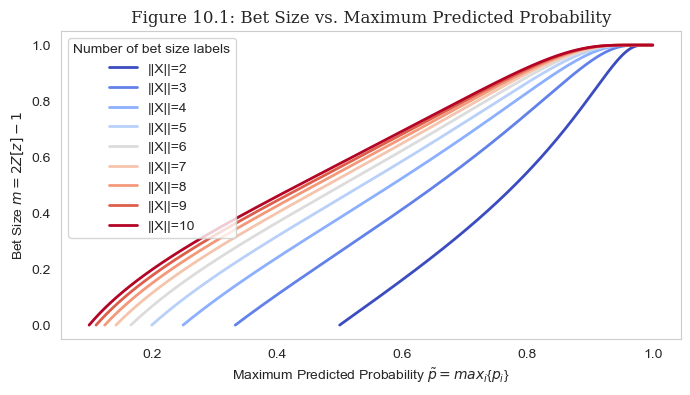

In [13]:
num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
sample_size = 10_000  # number of points to plot
colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))

# === Setup the t1 Series, also used for exercise 10.2 ===
# Create the array of dates.
start_date = dt.datetime(2000, 1, 1)  # starting at 01-JAN-2000
date_step = dt.timedelta(days=1)
dates = np.array([start_date + i*date_step for i in range(sample_size)])
# Create the array of shifted dates to be the end date of the bet.
shift_list = np.random.uniform(1., 25., sample_size)
shift_dt = np.array([dt.timedelta(days=d) for d in shift_list])
# Combine into a pandas.Series object
dates_shifted = dates + shift_dt
t1 = pd.Series(data=dates_shifted, index=dates)

# Start plotting loop.
fig_10_1, ax_10_1 = plt.subplots(figsize=(8, 4))

for num_classes in num_classes_list:
    # Create the array of random probabilities.
    min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1]
    P = np.linspace(min_prob, max_prob, sample_size, endpoint=False)  # range of maximum predicted probabilities to plot
    # Combine probabilities with 't1' Series into a DataFrame for the bet size function.
    events_n_classes = pd.DataFrame({'t1': t1, 'prob': P})
    events_n_classes['bet_size_prob'] = bet_size_probability(events=events_n_classes, prob=events_n_classes['prob'], num_classes=num_classes)
    ax_10_1.plot(events_n_classes['prob'], events_n_classes['bet_size_prob'], label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

ax_10_1.set_ylabel("Bet Size $m=2Z[z]-1$")
ax_10_1.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}")
ax_10_1.set_title("Figure 10.1: Bet Size vs. Maximum Predicted Probability", fontsize = 12, fontfamily = 'Serif')
ax_10_1.legend(loc="upper left", title="Number of bet size labels")
ax_10_1.grid(False)

plt.show()

In [15]:
from multiprocessing import cpu_count
import warnings
warnings.filterwarnings('ignore')
# Draw random numbers from a uniform distribution (all bets are long)
np.random.seed(0)
sample_size = 10000
P_t = np.random.uniform(.5, 1., sample_size)  # array of random from uniform dist.
# Create events DataFrame from P_t and t1 (previous exercise).
events_2_classes = pd.DataFrame({'t1': t1, 'prob': P_t})
events_2_classes['bet_size_prob'] = bet_size_probability(events=events_2_classes, prob=events_2_classes['prob'], num_classes=2)

events_2_classes['side'] = 1

avg_active_bet_sizes = avg_active_signals(events_2_classes.rename(columns={'bet_size_prob': 'signal'}), num_threads = cpu_count())
events_2_classes['avg_active_bet_size'] = avg_active_bet_sizes

print("The first 10 rows of the resulting DataFrame from Exercise 10.2:")
display(events_2_classes.head(10))
print("Summary statistics on the bet size columns:")
display(events_2_classes[['prob', 'bet_size_prob', 'avg_active_bet_size']].describe())


/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/fast_ewma.py:5: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((float64[:], int64), nopython = False, nogil = True)
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/fast_ewma.py:5: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit f

The first 10 rows of the resulting DataFrame from Exercise 10.2:


,t1,prob,bet_size_prob,side,avg_active_bet_size
2000-01-01,2000-01-20 22:47:31.375063,0.774407,0.488510,1,0.488510
2000-01-02,2000-01-18 08:17:19.706432,0.857595,0.693816,1,0.591163
2000-01-03,2000-01-05 01:30:05.145773,0.801382,0.550002,1,0.577443
2000-01-04,2000-01-10 22:09:54.532252,0.772442,0.484193,1,0.554130
2000-01-05,2000-01-15 19:09:30.462827,0.711827,0.360002,1,0.515304
2000-01-06,2000-01-28 20:49:22.512104,0.822947,0.602473,1,0.525799
2000-01-07,2000-01-19 10:39:45.625717,0.718794,0.373496,1,0.500415
2000-01-08,2000-01-31 00:17:12.957000,0.945887,0.951258,1,0.564821
2000-01-09,2000-01-15 11:35:05.092338,0.981831,0.999691,1,0.619180
2000-01-10,2000-01-19 17:00:31.292398,0.691721,0.321986,1,0.586158


Summary statistics on the bet size columns:


,prob,bet_size_prob,avg_active_bet_size
count,10000.000000,10000.000000,10000.000000
mean,0.748229,0.473318,0.471871
std,0.144803,0.312169,0.087838
min,0.500036,0.000058,0.166162
25%,0.622655,0.199764,0.413905
50%,0.746751,0.429563,0.473704
75%,0.874146,0.740689,0.530232
max,0.999989,1.000000,0.840650


In [16]:
events_10_3 = events_2_classes.copy()
concurrent_bets = get_concurrent_sides(events_10_3['t1'], events_10_3['side'])
active_long_max, active_short_max = concurrent_bets['active_long'].max(), concurrent_bets['active_short'].max()
print(f"  10.3(a) Maximum number of concurrent long bets: {active_long_max}")
print(f"  10.3(b) Maximum number of concurrent short bets: {active_short_max}")

# 10.3(c) Bet size as difference between fractions of concurrent long and short bets
# Handle possible division by zero.
df_budget = bet_size_budget(events_10_3['t1'], events_10_3['side'])
df_budget = df_budget.rename(columns={'bet_size': 'bet_size_budget'})

display(df_budget.head(10))

  10.3(a) Maximum number of concurrent long bets: 20
  10.3(b) Maximum number of concurrent short bets: 0


,t1,side,active_long,active_short,bet_size_budget
2000-01-01,2000-01-20 22:47:31.375063,1,1,0,0.05
2000-01-02,2000-01-18 08:17:19.706432,1,2,0,0.10
2000-01-03,2000-01-05 01:30:05.145773,1,3,0,0.15
2000-01-04,2000-01-10 22:09:54.532252,1,4,0,0.20
2000-01-05,2000-01-15 19:09:30.462827,1,5,0,0.25
2000-01-06,2000-01-28 20:49:22.512104,1,5,0,0.25
2000-01-07,2000-01-19 10:39:45.625717,1,6,0,0.30
2000-01-08,2000-01-31 00:17:12.957000,1,7,0,0.35
2000-01-09,2000-01-15 11:35:05.092338,1,8,0,0.40
2000-01-10,2000-01-19 17:00:31.292398,1,9,0,0.45


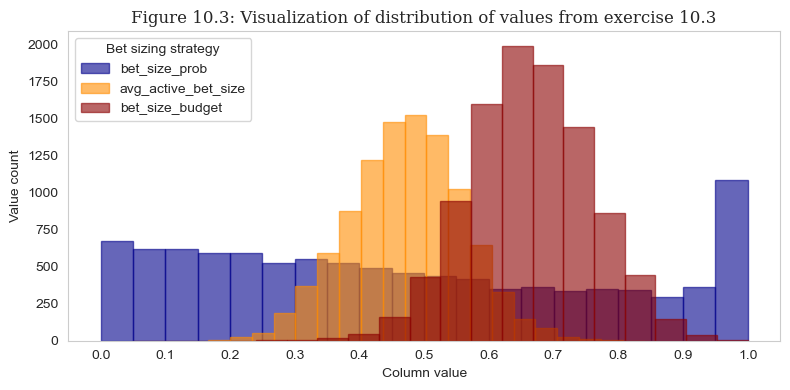

In [41]:
betsizes_10_3 = events_2_classes[['bet_size_prob', 'avg_active_bet_size']].copy()
betsizes_10_3['bet_size_budget'] = df_budget['bet_size_budget'].copy()

# Start plotting code.
fig_10_3, ax_10_3 = plt.subplots(figsize=(8, 4))
colors = iter(['darkblue','darkorange','darkred'])
n_bins = 20
for i, col in enumerate(['bet_size_prob', 'avg_active_bet_size', 'bet_size_budget']):
    coo = colors.__next__()
    ax_10_3.hist(betsizes_10_3[col], bins=n_bins, alpha = 0.6, color = coo, label=col, edgecolor = coo)
ax_10_3.set_xticks([i/10 for i in range(11)])
ax_10_3.set_xlabel("Column value")
ax_10_3.set_ylabel("Value count")
ax_10_3.set_title("Figure 10.3: Visualization of distribution of values from exercise 10.3", fontsize=12, fontfamily='Serif')
ax_10_3.legend(loc="upper left", title="Bet sizing strategy")
fig_10_3.tight_layout()
ax_10_3.grid(False)
plt.show()

베팅 사이즈는 다음과 같이 유도된다

$$m_t = c_{t,l}\frac{1}{\tilde c_l} - c_{t,s}\frac{1}{c_s}$$

한편, series $c_t = c_{t,l} - c_{t,s}$를 계산하였을 때의 betting sizes는

$$m_t=
\begin{cases}
\frac{F(c_t) - F(0)}{1 - F(0)}, ~~~~~ & \mbox{if } c_t \geq 0 \\
\frac{F(c_t) - F(0)}{F(0)}, & \mbox{if }c_t < 0 
\end{cases}$$

이다

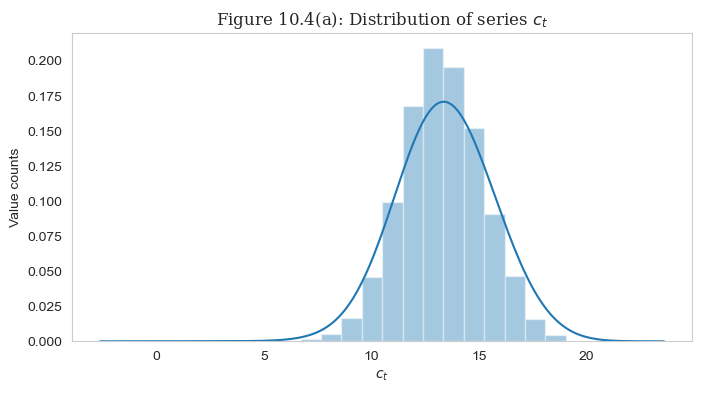

In [31]:
df_events_10_4 = df_budget.copy()
df_events_10_4['c_t'] = df_events_10_4['active_long'] - df_events_10_4['active_short']
fig_10_4, ax_10_4 = plt.subplots(figsize = (8,4))
ax_10_4a = sns.distplot(df_events_10_4['c_t'], bins = 20, kde=True, kde_kws={"bw":0.6}, norm_hist=False, ax=ax_10_4)
ax_10_4a.set_xlabel('$c_t$')
ax_10_4.set_ylabel("Value counts")
ax_10_4a.set_title("Figure 10.4(a): Distribution of series $c_t$", fontsize=12, fontfamily = 'Serif')
ax_10_4.grid(False)
plt.show()

In [42]:
df_reserve, params = bet_size_reserve(df_events_10_4['t1'],
                                      df_events_10_4['side'],
                                      fit_runs=100,
                                      epsilon=1e-05,
                                      factor=5,
                                      variant=2,
                                      max_iter=100_000,
                                      num_workers=8,
                                      return_parameters=True)

print(params)

|#########################| Completed 100 of 100 fitting rounds.

{'mu_1': 12.43427, 'mu_2': 13.47572, 'sigma_1': 2.89714, 'sigma_2': 1.93914, 'p_1': 0.03526}


In [43]:
df_reserve

,t1,side,active_long,active_short,c_t,bet_size
2000-01-01,2000-01-20 22:47:31.375063,1,1,0,1,0.000001
2000-01-02,2000-01-18 08:17:19.706432,1,2,0,2,0.000005
2000-01-03,2000-01-05 01:30:05.145773,1,3,0,3,0.000020
2000-01-04,2000-01-10 22:09:54.532252,1,4,0,4,0.000064
2000-01-05,2000-01-15 19:09:30.462827,1,5,0,5,0.000187
...,...,...,...,...,...,...
2027-05-14,2027-05-21 15:15:31.646947,1,15,0,15,0.785071
2027-05-15,2027-05-28 23:05:12.073303,1,14,0,14,0.610051
2027-05-16,2027-06-01 15:45:26.270153,1,13,0,13,0.409248
2027-05-17,2027-06-04 17:14:02.460103,1,13,0,13,0.409248


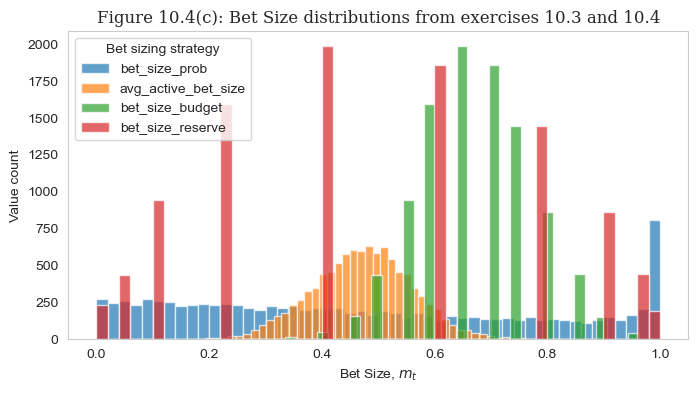

In [46]:
betsizes_10_4 = betsizes_10_3.copy()
betsizes_10_4['bet_size_reserve'] = df_reserve['bet_size']

fig_10_4c, ax_10_4c = plt.subplots(figsize = (8,4))
for c in betsizes_10_4.columns:
    ax_10_4c.hist(betsizes_10_4[c].to_numpy(), bins = 50, label = c, alpha = 0.7)
ax_10_4c.legend(loc='upper left', title="Bet sizing strategy")
ax_10_4c.set_xlabel("Bet Size, $m_t$")
ax_10_4c.set_ylabel("Value count")
ax_10_4c.set_title("Figure 10.4(c): Bet Size distributions from exercises 10.3 and 10.4", fontsize = 12, fontfamily = 'Serif')
ax_10_4c.grid(False)
ax_10_4.set_ylim((0, 2500))
plt.show()

In [47]:
print("Quantiles of the bet size values as calculated in the previous exercises:")
display(pd.concat([betsizes_10_4.quantile([0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999]),
                   betsizes_10_4.mean().to_frame(name='Mean').transpose()]))

Quantiles of the bet size values as calculated in the previous exercises:


,bet_size_prob,avg_active_bet_size,bet_size_budget,bet_size_reserve
0.001,0.000580,0.205495,0.35000,0.001475
0.01,0.006542,0.271795,0.45000,0.014285
0.05,0.037781,0.323563,0.50000,0.042311
0.25,0.199764,0.413905,0.60000,0.230978
0.5,0.429563,0.473704,0.65000,0.409248
0.75,0.740689,0.530232,0.75000,0.785071
0.95,0.997446,0.612328,0.85000,0.964616
0.99,1.000000,0.679439,0.90000,0.989561
0.999,1.000000,0.752508,0.95000,0.997470
Mean,0.473318,0.471871,0.67138,0.497262
